In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE as sm
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix 
from sklearn.metrics import f1_score,precision_recall_curve, roc_curve,  roc_auc_score, accuracy_score


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-card-customers/BankChurners.csv


In [2]:
df = pd.read_csv("../input/credit-card-customers/BankChurners.csv")
df.head(2)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994


In [3]:
print(df['Education_Level'].unique())
print(df['Marital_Status'].unique())
print(df['Card_Category'].unique())
print(df['Income_Category'].unique())

['High School' 'Graduate' 'Uneducated' 'Unknown' 'College' 'Post-Graduate'
 'Doctorate']
['Married' 'Single' 'Unknown' 'Divorced']
['Blue' 'Gold' 'Silver' 'Platinum']
['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +'
 'Unknown']


In [4]:
df.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],axis=1, inplace=True)
df.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1'],axis=1, inplace=True)
df.drop(['CLIENTNUM'],axis=1, inplace=True)

# EDA

In [5]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Attrition_Flag,10127,2,Existing Customer,8500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Customer_Age,10127.0,NaN,NaN,NaN,46.325960,8.016814,26.0,41.000,46.000,52.000,73.000
Gender,10127,2,F,5358,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependent_count,10127.0,NaN,NaN,NaN,2.346203,1.298908,0.0,1.000,2.000,3.000,5.000
Education_Level,10127,7,Graduate,3128,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital_Status,10127,4,Married,4687,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Income_Category,10127,6,Less than $40K,3561,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Card_Category,10127,4,Blue,9436,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Months_on_book,10127.0,NaN,NaN,NaN,35.928409,7.986416,13.0,31.000,36.000,40.000,56.000
Total_Relationship_Count,10127.0,NaN,NaN,NaN,3.812580,1.554408,1.0,3.000,4.000,5.000,6.000


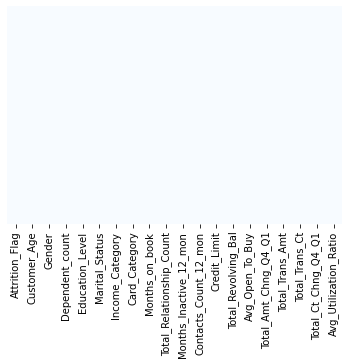

In [6]:
# Checking for null values

sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

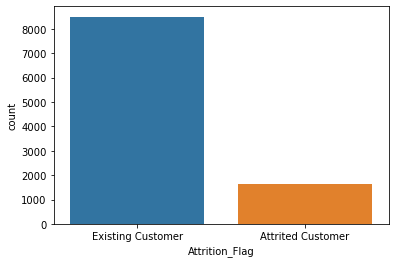

In [7]:
sns.countplot(x='Attrition_Flag',data = df, label = 'Counts')
plt.show()

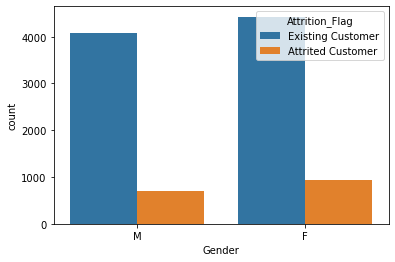

In [8]:
sns.countplot(x='Gender',data = df, hue='Attrition_Flag')
plt.show()

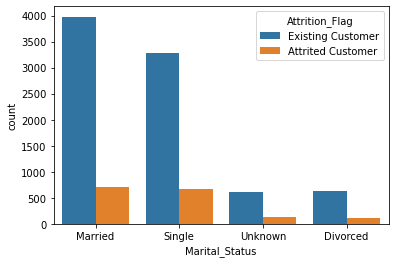

In [9]:
sns.countplot(x='Marital_Status',data = df, hue='Attrition_Flag')
plt.show()

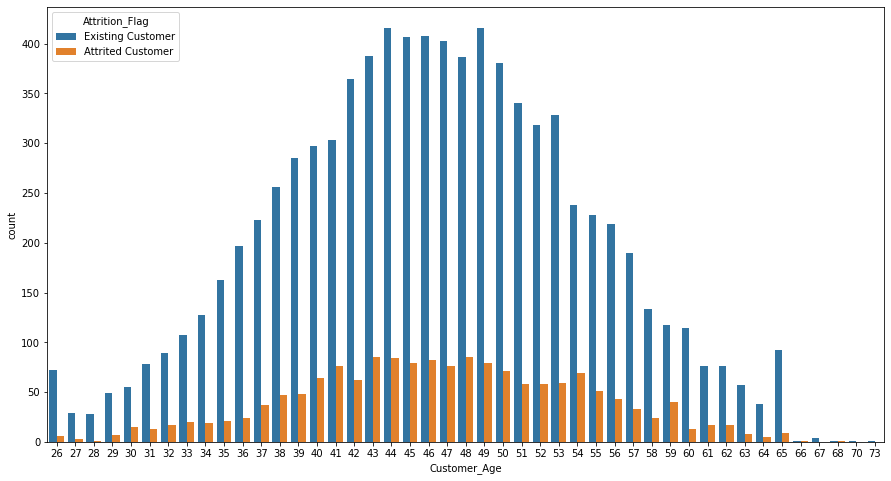

In [10]:
plt.figure(figsize=[15,8])
sns.countplot(x='Customer_Age',data = df, hue='Attrition_Flag')
plt.show()

<AxesSubplot:>

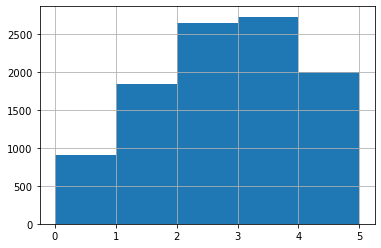

In [11]:
df['Dependent_count'].hist(bins=5)

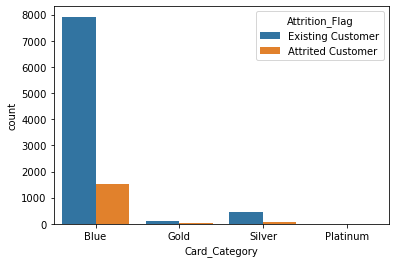

In [12]:
sns.countplot(x='Card_Category',data = df, hue='Attrition_Flag')
plt.show()

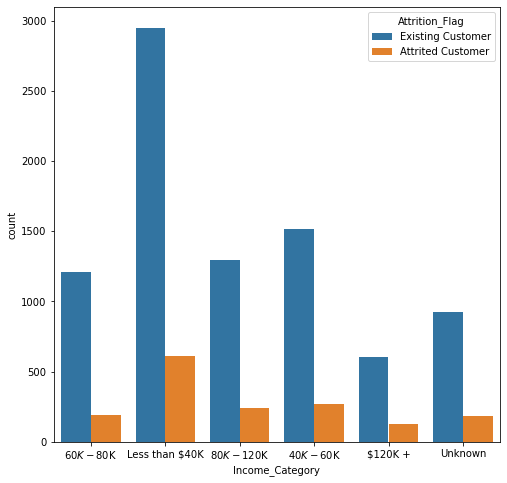

In [13]:
plt.figure(figsize=[8,8])
sns.countplot(x='Income_Category',data = df, hue='Attrition_Flag')
plt.show()

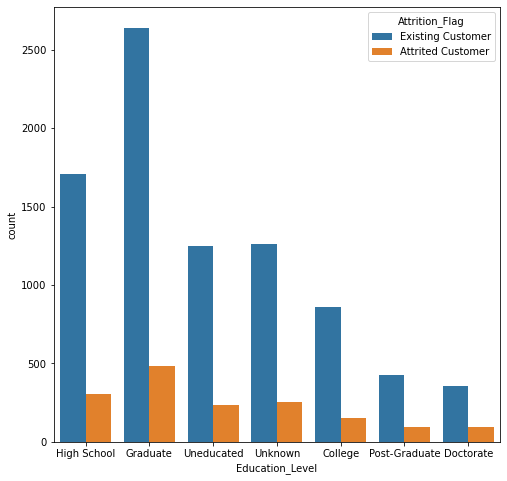

In [14]:
plt.figure(figsize=[8,8])
sns.countplot(x='Education_Level',data = df, hue='Attrition_Flag')
plt.show()

In [15]:
def update_education_unknown(df):
    edu_level = df[0]
    if edu_level == 'Unknown':
        return 'Edu_Unknown'
    else: 
        return edu_level

def update_marital_unknown(df):
    marital = df[0]
    if marital == 'Unknown':
        return 'Marital_Unknown'
    else: 
        return marital

In [16]:
df['Education_Level'] = df[['Education_Level']].apply(update_education_unknown,axis=1)
df['Marital_Status'] = df[['Marital_Status']].apply(update_marital_unknown,axis=1)

In [17]:
attir_flag = pd.get_dummies(df['Attrition_Flag'],drop_first=True)
df.drop(['Attrition_Flag'], axis=1, inplace=True)
df = pd.concat([df, attir_flag], axis=1)

In [18]:
corr_matrix = df.corr()
corr_matrix['Existing Customer'].sort_values(ascending = False)

Existing Customer           1.000000
Total_Trans_Ct              0.371403
Total_Ct_Chng_Q4_Q1         0.290054
Total_Revolving_Bal         0.263053
Avg_Utilization_Ratio       0.178410
Total_Trans_Amt             0.168598
Total_Relationship_Count    0.150005
Total_Amt_Chng_Q4_Q1        0.131063
Credit_Limit                0.023873
Avg_Open_To_Buy             0.000285
Months_on_book             -0.013687
Customer_Age               -0.018203
Dependent_count            -0.018991
Months_Inactive_12_mon     -0.152449
Contacts_Count_12_mon      -0.204491
Name: Existing Customer, dtype: float64

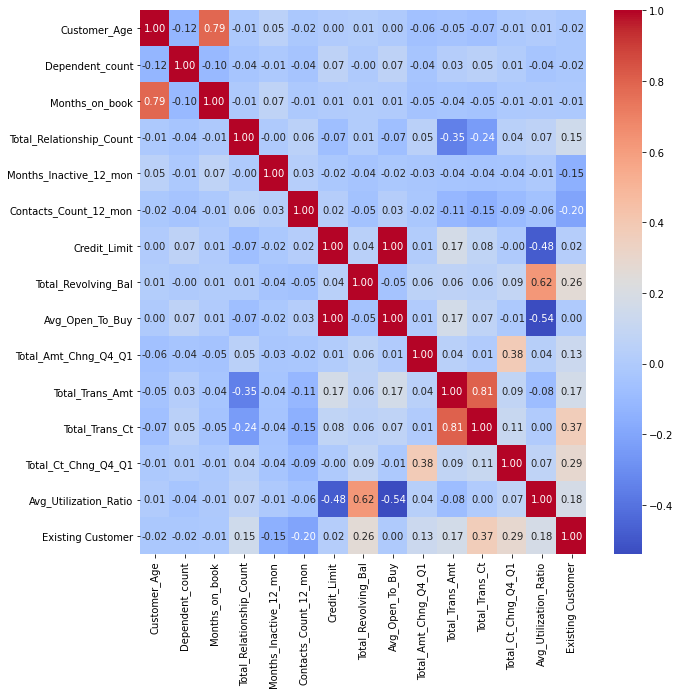

In [19]:
g = sns.heatmap(df.corr(),annot=True,fmt = ".2f", cmap = "coolwarm")
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

In [20]:
df2 = df.copy()

In [21]:
df2.drop(['Avg_Open_To_Buy'], axis=1, inplace=True) # dropping because of multicollinearity 

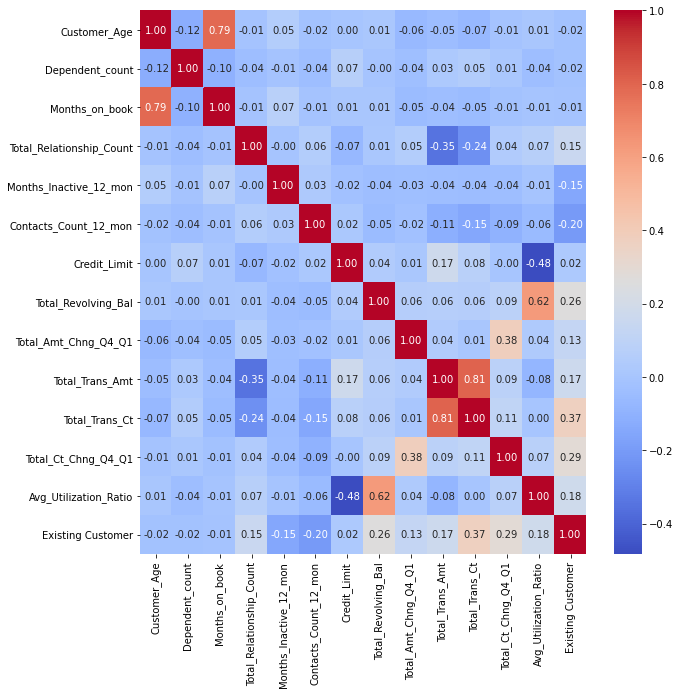

In [22]:
g = sns.heatmap(df2.corr(),annot=True,fmt = ".2f", cmap = "coolwarm")
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

In [23]:
# ENCODING THE CATEGORICAL VARIABLES
gender_flag = pd.get_dummies(df2['Gender'],drop_first=True)
df2.drop(['Gender'], axis=1, inplace=True)
df2 = pd.concat([df2, gender_flag], axis=1)

marital_flag = pd.get_dummies(df2['Marital_Status'],drop_first=True)
df2.drop(['Marital_Status'], axis=1, inplace=True)
df2 = pd.concat([df2, marital_flag], axis=1)

edu_flag = pd.get_dummies(df2['Education_Level'],drop_first=True)
df2.drop(['Education_Level'], axis=1, inplace=True)
df2 = pd.concat([df2, edu_flag], axis=1)

card_flag = pd.get_dummies(df2['Card_Category'],drop_first=True)
df2.drop(['Card_Category'], axis=1, inplace=True)
df2 = pd.concat([df2, card_flag], axis=1)

income_flag = pd.get_dummies(df2['Income_Category'],drop_first=True)
df2.drop(['Income_Category'], axis=1, inplace=True)
df2 = pd.concat([df2, income_flag], axis=1)

In [24]:
df2.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,...,Post-Graduate,Uneducated,Gold,Platinum,Silver,$40K - $60K,$60K - $80K,$80K - $120K,Less than $40K,Unknown
0,45,3,39,5,1,3,12691.0,777,1.335,1144,...,0,0,0,0,0,0,1,0,0,0
1,49,5,44,6,1,2,8256.0,864,1.541,1291,...,0,0,0,0,0,0,0,0,1,0
2,51,3,36,4,1,0,3418.0,0,2.594,1887,...,0,0,0,0,0,0,0,1,0,0
3,40,4,34,3,4,1,3313.0,2517,1.405,1171,...,0,0,0,0,0,0,0,0,1,0
4,40,3,21,5,1,0,4716.0,0,2.175,816,...,0,1,0,0,0,0,1,0,0,0


In [25]:
df2.columns

Index(['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct',
       'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Existing Customer',
       'M', 'Marital_Unknown', 'Married', 'Single', 'Doctorate', 'Edu_Unknown',
       'Graduate', 'High School', 'Post-Graduate', 'Uneducated', 'Gold',
       'Platinum', 'Silver', '$40K - $60K', '$60K - $80K', '$80K - $120K',
       'Less than $40K', 'Unknown'],
      dtype='object')

# TRAIN TEST SPLIT

In [26]:
from sklearn.model_selection import train_test_split
X = df2.loc[:, df2.columns != 'Existing Customer'] 
y = df2.loc[:,df2.columns == 'Existing Customer']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 10, stratify=y)

In [27]:
print("Number transactions X_train dataset: ", X_train.shape) 
print("Number transactions y_train dataset: ", y_train.shape) 
print("Number transactions X_test dataset: ", X_test.shape) 
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (8101, 31)
Number transactions y_train dataset:  (8101, 1)
Number transactions X_test dataset:  (2026, 31)
Number transactions y_test dataset:  (2026, 1)


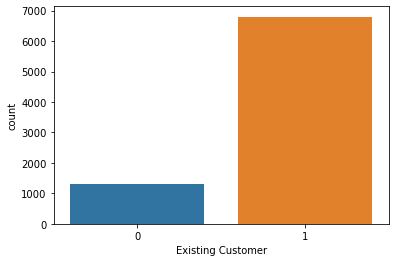

In [28]:
sns.countplot(x = 'Existing Customer',data = y_train)
plt.show()

# HANDLING IMBALANCED CLASS

In [29]:
smo = sm(random_state = 2) 
X_train_res, y_train_res = smo.fit_sample(X_train, y_train.values.ravel()) 

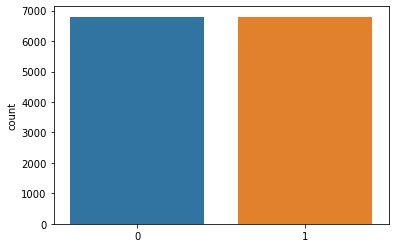

In [30]:
l = list(y_train_res)
sns.countplot(x = l)
plt.show()

# SCALING DATASET

In [31]:
sc = StandardScaler()
X_train_res= sc.fit_transform(X_train_res)

In [32]:
X_test = sc.transform(X_test)

In [33]:
def display_scores(scores):
    print('Scores',scores)
    print('Mean',scores.mean())
    print('Standard Deviation',scores.std())

In [34]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

# MODELING

### K Neighbours Classifier

In [35]:
# k = KNeighborsClassifier()
# k_param_grid = {"n_neighbors":[5,10,15,20],
#                "metric" : ['minkowski','euclidean','manhattan',"chebyshev"]
#                }
# k_NN = GridSearchCV(k,param_grid = k_param_grid, cv=5, scoring="accuracy", n_jobs= -1, verbose = 2)
# k_NN.fit(X_train_res,y_train_res)
# k_NN.best_estimator_

In [36]:
# k_NN.best_score_

In [37]:
k = KNeighborsClassifier(metric='manhattan')
k_score = cross_val_score(k, X_train_res, y_train_res, cv=5, scoring="accuracy")
display_scores(k_score)

Scores [0.82426471 0.95404412 0.96727941 0.95917617 0.95292387]
Mean 0.9315376544144691
Standard Deviation 0.05387533236442255


In [38]:
y_train_pred = cross_val_predict(k, X_train_res, y_train_res, cv=5)

In [39]:
print(precision_score(y_train_res, y_train_pred))
print(recall_score(y_train_res, y_train_pred))
print(f1_score(y_train_res, y_train_pred))
print(roc_auc_score(y_train_res, y_train_pred))

0.937910447761194
0.9242535667009855
0.9310319282909846
0.9315340491248714


In [40]:
knn = k.fit(X_train_res,y_train_res)
knn_pred = knn.predict(X_test)  #PREDICTION
print(accuracy_score(y_test, knn_pred))

0.8657453109575518


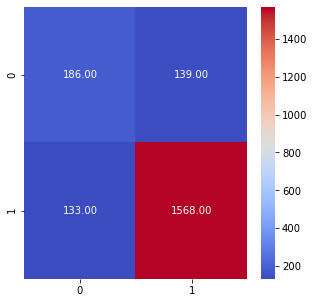

In [41]:
cfm_vpc = confusion_matrix(y_test,knn_pred)
sns.heatmap(cfm_vpc, annot=True,fmt = ".2f", cmap = "coolwarm")
fig=plt.gcf()
fig.set_size_inches(5,5)
plt.show()

0.9185705916813123
0.9218106995884774
0.92018779342723
0.7470591959480849


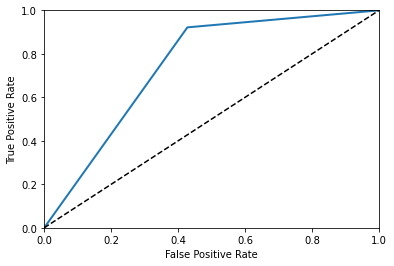

In [42]:
print(precision_score(y_test,knn_pred))
print(recall_score(y_test,knn_pred))
print(f1_score(y_test,knn_pred))
print(roc_auc_score(y_test,knn_pred))
fpr, tpr, thresholds = roc_curve(y_test,knn_pred)
plot_roc_curve(fpr, tpr)
plt.show()

### SVC

In [43]:
# svc_c = SVC(random_state = 2)
# svc_param_grid = {'kernel': ['sigmoid','rbf'], 
#                   'gamma': [ 0.001, 0.01, 0.1, 1],
#                   'C': [1, 10, 20],
#                  'probability': [True],
#                   'tol': [0.001, 0.01, 0.1, 1],
#                  'decision_function_shape':['ovr'],
#                  }
# gsSVMC = GridSearchCV(svc_c,param_grid = svc_param_grid, cv=5, scoring="accuracy", 
#                       n_jobs= -1, verbose = 1)
# gsSVMC.fit(X_train_res,y_train_res)
# gsSVMC.best_estimator_

In [44]:
# gsSVMC.best_score_

In [45]:
svc_c = SVC(C=20, gamma=0.01, probability=True, random_state=2, tol=0.1)
c_score = cross_val_score(svc_c, X_train_res, y_train_res, cv=5, scoring="accuracy")
display_scores(c_score)

Scores [0.68419118 0.97169118 0.96654412 0.9709452  0.96984185]
Mean 0.9126427049304457
Standard Deviation 0.11423931786703731


In [46]:
y_train_pred = cross_val_predict(svc_c, X_train_res, y_train_res, cv=5)

In [47]:
print(precision_score(y_train_res, y_train_pred))
print(recall_score(y_train_res, y_train_pred))
print(f1_score(y_train_res, y_train_pred))
print(roc_auc_score(y_train_res, y_train_pred))

0.8819605173587475
0.9527871745844977
0.9160067873303168
0.9126342109133696


In [48]:
svc = svc_c.fit(X_train_res,y_train_res)
svc_pred = svc.predict(X_test)
print(accuracy_score(y_test, svc_pred))

0.9190523198420533


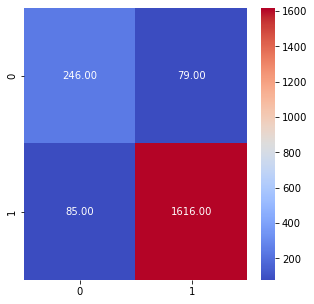

In [49]:
cfm_vpc = confusion_matrix(y_test,svc_pred)
sns.heatmap(cfm_vpc, annot=True,fmt = ".2f", cmap = "coolwarm")
fig=plt.gcf()
fig.set_size_inches(5,5)
plt.show()

0.9533923303834808
0.9500293944738389
0.9517078916372202
0.853476235698458


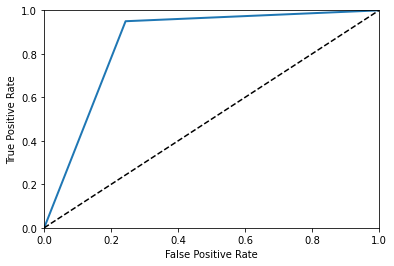

In [50]:
print(precision_score(y_test, svc_pred))
print(recall_score(y_test, svc_pred))
print(f1_score(y_test, svc_pred))
print(roc_auc_score(y_test, svc_pred))
fpr, tpr, thresholds = roc_curve(y_test, svc_pred)
plot_roc_curve(fpr, tpr)
plt.show()

### Decision Tree Classifier

In [51]:
# DTC = DecisionTreeClassifier()
# DTC_param_grid = {'criterion' : ['entropy'],
#                   'max_depth':[2,3,4,5],
#                   "min_samples_split": [1,2,3,4,5,6,7,8,9,10],
#                   "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10]
#                  }
# gsDTC = GridSearchCV(DTC,param_grid = DTC_param_grid, cv=5, scoring="accuracy", n_jobs= -1, verbose = 2)
# gsDTC.fit(X_train_res,y_train_res)
# gsDTC.best_estimator_

In [52]:
# gsDTC.best_score_

In [53]:
DTC = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=9,
                       min_samples_split=8)
c_score = cross_val_score(DTC, X_train_res, y_train_res, cv=5, scoring="accuracy")
display_scores(c_score)

Scores [0.90441176 0.91911765 0.91985294 0.91320338 0.91724899]
Mean 0.9147669450273673
Standard Deviation 0.005667997690943966


In [54]:
y_train_pred = cross_val_predict(DTC, X_train_res, y_train_res, cv=5)

In [55]:
print(precision_score(y_train_res, y_train_pred))
print(recall_score(y_train_res, y_train_pred))
print(f1_score(y_train_res, y_train_pred))
print(roc_auc_score(y_train_res, y_train_pred))

0.9172832198875407
0.9117517281953228
0.9145091096850336
0.9147668774819826


In [56]:
dt = DTC.fit(X_train_res,y_train_res)
dtc_pred = dt.predict(X_test)  #PREDICTION
print(accuracy_score(y_test, dtc_pred))


0.9076999012833169


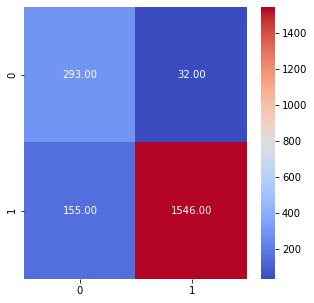

In [57]:
cfm_vpc = confusion_matrix(y_test, dtc_pred)
sns.heatmap(cfm_vpc, annot=True,fmt = ".2f", cmap = "coolwarm")
fig=plt.gcf()
fig.set_size_inches(5,5)
plt.show()

0.9797211660329531
0.9088771310993533
0.942970417810308
0.9052077963189075


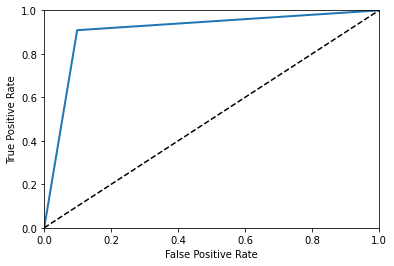

In [58]:
print(precision_score(y_test, dtc_pred))
print(recall_score(y_test, dtc_pred))
print(f1_score(y_test, dtc_pred))
print(roc_auc_score(y_test, dtc_pred))
fpr, tpr, thresholds = roc_curve(y_test, dtc_pred)
plot_roc_curve(fpr, tpr)
plt.show()

### Random Forest Classifier

In [59]:
# RFC = RandomForestClassifier()


# rf_param_grid = {"max_depth": [2,3,4,5],
#               "max_features": [1,2,3,4,5],
#               "min_samples_split": [2,3,4,5],
#               "min_samples_leaf": [1,2,3,4,5],
#               "bootstrap": [False],
#               "n_estimators" :[50,100,150,200],
#               "criterion": ["entropy"]}

# gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=5, scoring="accuracy", n_jobs= -1, verbose = 2)
# gsRFC.fit(X_train_res,y_train_res)
# gsRFC.best_estimator_

In [60]:
# gsRFC.best_score_

In [61]:
RFC = RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=5,
                       max_features=5, n_estimators=200)
c_score = cross_val_score(RFC, X_train_res, y_train_res, cv=5, scoring="accuracy")
display_scores(c_score)

Scores [0.87830882 0.93308824 0.92647059 0.92019125 0.92423685]
Mean 0.9164591491248946
Standard Deviation 0.019527539396948988


In [62]:
y_train_pred = cross_val_predict(RFC, X_train_res, y_train_res, cv=5)

In [63]:
print(precision_score(y_train_res, y_train_pred))
print(recall_score(y_train_res, y_train_pred))
print(f1_score(y_train_res, y_train_pred))
print(roc_auc_score(y_train_res, y_train_pred))

0.9078947368421053
0.9235181644359465
0.9156398104265403
0.9149139579349904


In [64]:
rf = RFC.fit(X_train_res,y_train_res)
rfc_pred = rf.predict(X_test)  #PREDICTION
print(accuracy_score(y_test, rfc_pred))

0.9111549851924975


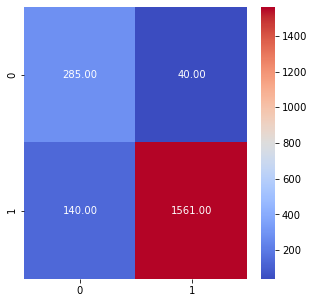

In [65]:
cfm_vpc = confusion_matrix(y_test, rfc_pred)
sns.heatmap(cfm_vpc, annot=True,fmt = ".2f", cmap = "coolwarm")
fig=plt.gcf()
fig.set_size_inches(5,5)
plt.show()


0.9750156152404748
0.9176954732510288
0.9454875832828589
0.8973092750870528


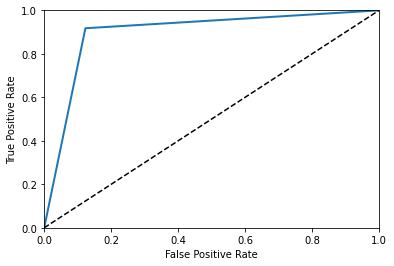

In [66]:
print(precision_score(y_test, rfc_pred))
print(recall_score(y_test, rfc_pred))
print(f1_score(y_test, rfc_pred))
print(roc_auc_score(y_test, rfc_pred))
fpr, tpr, thresholds = roc_curve(y_test, rfc_pred)
plot_roc_curve(fpr, tpr)
plt.show()

### Logistic Regression

In [67]:
# lr_ = LogisticRegression() 
# lr_param_grid = {'penalty':['l1','l2'],
#                 'tol':[1e-4,1e-3,1e-2,1e-5],
#                  'C':[0.1, 1, 100],
#                  'multi_class':['ovr'],
#                  'max_iter':[1000],
#                  'solver':['newton_cg','sag','saga','lbfgs']
#                 }
# gslr = GridSearchCV(lr_,param_grid = lr_param_grid, cv=5, scoring="accuracy", n_jobs= -1, verbose = 2)
# gslr.fit(X_train_res,y_train_res)

In [68]:
# gslr_best = gslr.best_estimator_
# gslr_best

In [69]:
lr = LogisticRegression(C=0.1, max_iter=1000, multi_class='ovr', solver='saga',
                   tol=0.001) 
c_score = cross_val_score(lr, X_train_res, y_train_res, cv=5, scoring="accuracy")
display_scores(c_score)

Scores [0.65808824 0.95147059 0.94926471 0.95917617 0.94887826]
Mean 0.8933755922376306
Standard Deviation 0.11770218709439907


In [70]:
y_train_pred = cross_val_predict(lr, X_train_res, y_train_res, cv=5)

In [71]:
print(precision_score(y_train_res, y_train_pred))
print(recall_score(y_train_res, y_train_pred))
print(f1_score(y_train_res, y_train_pred))
print(roc_auc_score(y_train_res, y_train_pred))


0.8631364562118127
0.9349904397705545
0.8976277887602373
0.8933666715693486


In [72]:
lrc = lr.fit(X_train_res,y_train_res)
lr_pred = lrc.predict(X_test)  #PREDICTION
print(accuracy_score(y_test, lr_pred))

0.8721618953603159


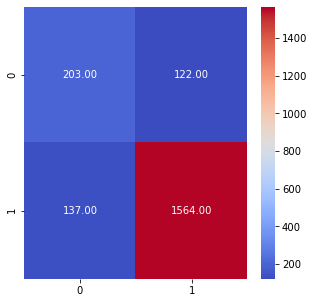

In [73]:
cfm_vpc = confusion_matrix(y_test,lr_pred)
sns.heatmap(cfm_vpc, annot=True,fmt = ".2f", cmap = "coolwarm")
fig=plt.gcf()
fig.set_size_inches(5,5)
plt.show()

0.9276393831553974
0.9194591416813639
0.9235311485090051
0.7720372631483741


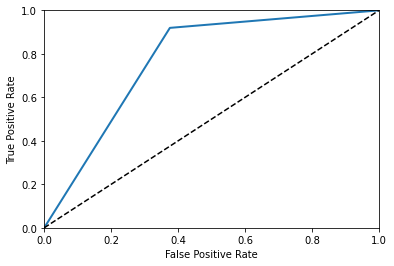

In [74]:
print(precision_score(y_test,lr_pred))
print(recall_score(y_test,lr_pred))
print(f1_score(y_test,lr_pred))
print(roc_auc_score(y_test,lr_pred))
fpr, tpr, thresholds = roc_curve(y_test,lr_pred)
plot_roc_curve(fpr, tpr)
plt.show()

## *Decision Tree Classifier and Random Forest are the two classifiers which gave us satisfactory results. Rest classifiers overfitted by a big margin.*